In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch
from RVAE import RVAE, beta_elbow
from datasets import load_dataset
import torch.optim as optim
import torch.utils.data
from IPython.display import clear_output

In [2]:
# full_data=pd.concat([X2,y], axis=1)
# values_to_match=['ARP_poisioning', 'DDOS_Slowloris', 'DOS_SYN_Hping',
#                  'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN',
#                  'NMAP_OS_DETECTION', 'NMAP_TCP_scan', 'NMAP_UDP_SCAN',
#                  'NMAP_XMAS_TREE_SCAN']
# anomalous_data=full_data[full_data['Attack_type'].isin(values_to_match)]
# anomalous_data=anomalous_data.iloc[:, :-1]
# # anomalous_data
# print(anomalous_data[anomalous_data.notna().any(axis=1)].shape, anomalous_data.shape)
# anomalous_data

In [3]:
dataset = load_dataset("aamui/rt_iot_2022")

In [4]:
dataset_full=dataset['train'].to_pandas().filter(regex='^((?!max|min|avg|std).)*$')
normal_types = ['Wipro_bulb', 'Thing_Speak', 'MQTT_Publish', 'Alexa']
attack_types = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION',
    'NMAP_TCP_scan', 'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH','NMAP_FIN_SCAN'
]

dataset_full['label'] = dataset_full['Attack_type'].apply(lambda x: 0 if x in normal_types else 1)
targets=dataset_full['label']
X=dataset_full.drop(['Attack_type', 'label'], axis=1)

# droped id cols + proto, service
X=X.drop(X.columns[[0,1,2,3]], axis=1)

scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(X)

In [5]:
scaled_data

array([[2.70384263e-07, 2.30149597e-04, 9.88924051e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.59325314e-04, 3.65937860e-02, 1.42405063e-02, ...,
        1.81429770e-01, 4.90730144e-02, 1.81429770e-01],
       [9.98208074e-06, 1.61104718e-03, 6.92246835e-04, ...,
        4.45563439e-01, 4.45563439e-01, 1.62508583e-02],
       ...,
       [2.76137120e-10, 2.30149597e-04, 9.88924051e-05, ...,
        1.56252384e-02, 0.00000000e+00, 1.56252384e-02],
       [2.76137120e-10, 2.30149597e-04, 9.88924051e-05, ...,
        1.56252384e-02, 0.00000000e+00, 1.56252384e-02],
       [2.76137120e-10, 2.30149597e-04, 9.88924051e-05, ...,
        1.56252384e-02, 0.00000000e+00, 1.56252384e-02]])

In [6]:
# https://arxiv.org/pdf/2006.08204
# def beta_elbow(x_hat, x, beta, N, z_mu, z_sigma):
#     # this loss assumes that all columns are continuous which i believe is true
#     beta_cross_entropy=-((beta+1)/beta) * torch.mean(torch.exp((-0.5 * z_sigma * beta) * torch.sum((x_hat - x)**2))-1)
#     kl_div=torch.mean(0.5 * torch.sum(1 + 2 * torch.log(z_sigma) - (z_mu**2)  - (z_sigma**2), -1))
#     return beta_cross_entropy + kl_div

In [7]:
def plot_loss(loss):
    epoch = len(loss)
    plt.plot(1+np.arange(epoch), loss, marker='o', color='red')
    plt.ylim(bottom=0)
    plt.title('ELBO Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('ELBO Loss')
    plt.grid()

In [8]:
train=torch.utils.data.TensorDataset(torch.from_numpy(X.values).float())
trian_loader=torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

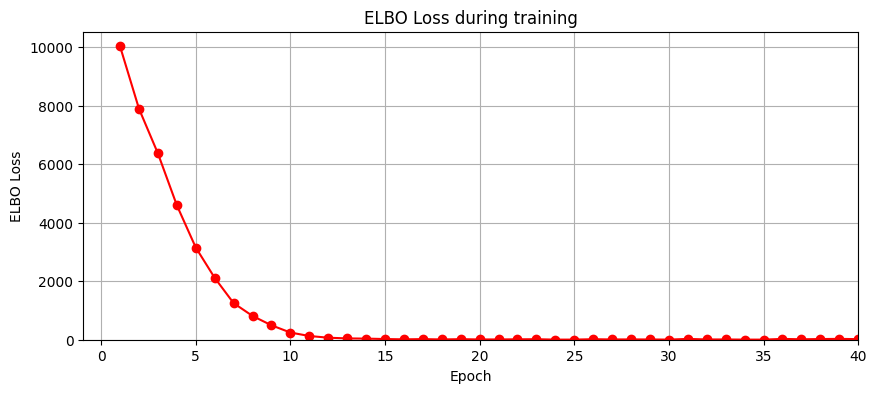

Epoch [40/40], ELBO Loss: 19.5257


In [12]:
rvae=RVAE(latent_dim=5, in_out_dim=X.shape[1])
optimizer=optim.Adam(rvae.parameters(), 1e-5)
beta_losses=[]
epochs=40

for epoch in range(epochs):
    for data in trian_loader:
        data=data[0]
        optimizer.zero_grad()
        recon, mu, sigma=rvae(data)
        loss=beta_elbow(recon, data, 1e-3, mu, sigma)
        loss.backward()
        optimizer.step()
    beta_losses.append(loss.item())

    clear_output(wait=True)
    plt.figure(figsize=(10,4))
    plot_loss(beta_losses)
    plt.xlim(right=40)
    plt.show()

    print(f'Epoch [{epoch + 1}/{40}], ELBO Loss: {loss.item():.4f}')
